# LLMSQL2 - Data Exploration

This notebook explores the Text-to-SQL datasets from the text2sql-data repository.

In [1]:
import sys
sys.path.insert(0, '..')

import json
from pathlib import Path
import pandas as pd

# Project paths
DATA_DIR = Path('../data/text2sql-data/data')
print(f"Data directory: {DATA_DIR}")
print(f"Exists: {DATA_DIR.exists()}")

Data directory: ..\data\text2sql-data\data
Exists: True


## 1. List Available Datasets

In [2]:
# List all JSON files (datasets)
datasets = list(DATA_DIR.glob('*.json'))
print("Available datasets:")
for ds in datasets:
    print(f"  - {ds.stem}")

Available datasets:
  - academic
  - advising
  - atis
  - geography
  - imdb
  - restaurants
  - scholar
  - spider
  - yelp


## 2. Explore a Sample Dataset (Geography)

In [3]:
# Load geography dataset as it's smaller and good for testing
with open(DATA_DIR / 'geography.json', 'r') as f:
    geography_data = json.load(f)

print(f"Type: {type(geography_data)}")
if isinstance(geography_data, dict):
    print(f"Keys: {geography_data.keys()}")
elif isinstance(geography_data, list):
    print(f"Number of examples: {len(geography_data)}")
    print(f"\nFirst example:")
    print(json.dumps(geography_data[0], indent=2))

Type: <class 'list'>
Number of examples: 246

First example:
{
  "query-split": "train",
  "sentences": [
    {
      "question-split": "dev",
      "text": "what is the biggest city in state_name0",
      "variables": {
        "state_name0": "arizona"
      }
    },
    {
      "question-split": "dev",
      "text": "what state_name0 city has the largest population",
      "variables": {
        "state_name0": "texas"
      }
    },
    {
      "question-split": "dev",
      "text": "what is the largest city in state_name0",
      "variables": {
        "state_name0": "missouri"
      }
    },
    {
      "question-split": "test",
      "text": "what is the biggest city in state_name0",
      "variables": {
        "state_name0": "kansas"
      }
    },
    {
      "question-split": "test",
      "text": "what is the biggest city in state_name0",
      "variables": {
        "state_name0": "louisiana"
      }
    },
    {
      "question-split": "test",
      "text": "what is the lar

In [ ]:
# Extract and display examples
examples = []

# Handle nested structure
if isinstance(geography_data, dict):
    for key, sentences in geography_data.items():
        for sent in sentences:
            examples.append({
                'question': sent.get('text', sent.get('sentence', '')),
                'sql': sent.get('sql', [''])[0] if isinstance(sent.get('sql'), list) else sent.get('sql', '')
            })

df = pd.DataFrame(examples[:20])
df

## 3. Explore Schema Information

In [ ]:
# Load schema
schema_df = pd.read_csv(DATA_DIR / 'geography-schema.csv')
schema_df

## 4. Dataset Statistics

In [4]:
# Count examples per dataset
stats = []

for ds_file in DATA_DIR.glob('*.json'):
    try:
        with open(ds_file, 'r') as f:
            data = json.load(f)
        
        count = 0
        if isinstance(data, list):
            count = len(data)
        elif isinstance(data, dict):
            for key, items in data.items():
                if isinstance(items, list):
                    count += len(items)
        
        stats.append({'dataset': ds_file.stem, 'examples': count})
    except Exception as e:
        stats.append({'dataset': ds_file.stem, 'examples': f'Error: {e}'})

stats_df = pd.DataFrame(stats)
stats_df.sort_values('examples', ascending=False)

,dataset,examples
7,spider,5183
2,atis,947
3,geography,246
1,advising,205
6,scholar,193
0,academic,185
8,yelp,110
4,imdb,89
5,restaurants,23


## 5. Test Model Loading (Optional - requires GPU)

In [5]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.4.1+cpu
CUDA available: False


## 6. Load and Test TinyLlama-Text2SQL Model

**Note:** Without GPU, inference will be slow. For production use, consider using a GPU or quantization.

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import warnings
warnings.filterwarnings('ignore')

# Load TinyLlama-1.1B-Text2SQL (smaller model, works on CPU)
MODEL_NAME = "ManthanKulakarni/TinyLlama-1.1B-Text2SQL"

print(f"Loading model: {MODEL_NAME}")
print("This may take a few minutes on first run (downloading ~2GB)...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,  # Use float32 for CPU
    device_map="cpu",
    trust_remote_code=True
)

print("Model loaded successfully!")

c:\Users\Dimitris\Documents\ASPS\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model: ManthanKulakarni/TinyLlama-1.1B-Text2SQL
This may take a few minutes on first run (downloading ~2GB)...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Model loaded successfully!


In [7]:
# Test the model with a sample question
def generate_sql(question, schema_text="", max_new_tokens=128):
    """Generate SQL from a natural language question."""
    
    # TinyLlama chat template
    prompt = f"""<|system|>
You are a helpful assistant that converts natural language questions to SQL queries.</s>
<|user|>
{schema_text}

Question: {question}

Generate the SQL query:</s>
<|assistant|>
"""
    
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract SQL from response (after the assistant marker)
    if "<|assistant|>" in response:
        sql = response.split("<|assistant|>")[-1].strip()
    else:
        sql = response.split("Generate the SQL query:")[-1].strip()
    
    return sql

# Test with a simple question
test_question = "What is the largest city in Texas?"
print(f"Question: {test_question}")
print(f"Generating SQL... (this may take ~30 seconds on CPU)")

sql_result = generate_sql(test_question)
print(f"\nGenerated SQL:\n{sql_result}")

Question: What is the largest city in Texas?
Generating SQL... (this may take ~30 seconds on CPU)

Generated SQL:
### Context:
CREATE TABLE table_name_2 (city VARCHAR, state VARCHAR)
### Question:
What is the city of the state of Texas?
### Answer:
SELECT city FROM table_name_2 WHERE state = "texas" ORDER BY 100000000000000000000000000000000000000000000000000000000000000000000


## 7. Evaluate on Geography Dataset (Sample)

In [8]:
# Load geography schema for context
schema_text = """
CREATE TABLE state (
  state_name TEXT PRIMARY KEY,
  population INTEGER,
  area INTEGER,
  country_name TEXT,
  capital TEXT,
  density REAL
);

CREATE TABLE city (
  city_name TEXT,
  population INTEGER,
  country_name TEXT,
  state_name TEXT
);

CREATE TABLE river (
  river_name TEXT PRIMARY KEY,
  length INTEGER,
  country_name TEXT,
  traverse TEXT
);

CREATE TABLE border_info (
  state_name TEXT,
  border TEXT
);

CREATE TABLE highlow (
  state_name TEXT,
  highest_elevation TEXT,
  lowest_point TEXT,
  highest_point TEXT,
  lowest_elevation INTEGER
);

CREATE TABLE mountain (
  mountain_name TEXT PRIMARY KEY,
  mountain_altitude INTEGER,
  country_name TEXT,
  state_name TEXT
);

CREATE TABLE lake (
  lake_name TEXT PRIMARY KEY,
  area INTEGER,
  country_name TEXT,
  state_name TEXT
);
"""

print("Geography database schema loaded.")
print(schema_text[:500] + "...")

Geography database schema loaded.

CREATE TABLE state (
  state_name TEXT PRIMARY KEY,
  population INTEGER,
  area INTEGER,
  country_name TEXT,
  capital TEXT,
  density REAL
);

CREATE TABLE city (
  city_name TEXT,
  population INTEGER,
  country_name TEXT,
  state_name TEXT
);

CREATE TABLE river (
  river_name TEXT PRIMARY KEY,
  length INTEGER,
  country_name TEXT,
  traverse TEXT
);

CREATE TABLE border_info (
  state_name TEXT,
  border TEXT
);

CREATE TABLE highlow (
  state_name TEXT,
  highest_elevation TEXT,
  lowes...


In [9]:
# Prepare evaluation samples from geography dataset
def prepare_geography_samples(data, n_samples=5):
    """Extract n samples from geography dataset."""
    samples = []
    
    for item in data[:n_samples]:
        # Get first sentence and SQL
        sentence = item['sentences'][0]
        sql = item['sql'][0]
        variables = sentence.get('variables', {})
        
        # Replace variables in text and SQL
        text = sentence['text']
        sql_filled = sql
        for var_name, var_value in variables.items():
            text = text.replace(var_name, var_value)
            sql_filled = sql_filled.replace(f'"{var_name}"', f'"{var_value}"')
        
        samples.append({
            'question': text,
            'gold_sql': sql_filled
        })
    
    return samples

# Get 5 samples
samples = prepare_geography_samples(geography_data, n_samples=5)

print("Evaluation samples:")
for i, s in enumerate(samples):
    print(f"\n{i+1}. Question: {s['question']}")
    print(f"   Gold SQL: {s['gold_sql'][:80]}...")

Evaluation samples:

1. Question: what is the biggest city in arizona
   Gold SQL: SELECT CITYalias0.CITY_NAME FROM CITY AS CITYalias0 WHERE CITYalias0.POPULATION ...

2. Question: which rivers run through the state with the largest city in the us
   Gold SQL: SELECT RIVERalias0.RIVER_NAME FROM RIVER AS RIVERalias0 WHERE RIVERalias0.TRAVER...

3. Question: how big is texas
   Gold SQL: SELECT STATEalias0.AREA FROM STATE AS STATEalias0 WHERE STATEalias0.STATE_NAME =...

4. Question: how many people live in washington
   Gold SQL: SELECT STATEalias0.POPULATION FROM STATE AS STATEalias0 WHERE STATEalias0.STATE_...

5. Question: what state has the smallest population
   Gold SQL: SELECT STATEalias0.STATE_NAME FROM STATE AS STATEalias0 WHERE STATEalias0.POPULA...


In [10]:
# Run mini evaluation
from tqdm import tqdm
import time

def extract_sql_from_output(output):
    """Extract SQL from model output."""
    # Look for SELECT statement
    output_upper = output.upper()
    if "SELECT" in output_upper:
        start_idx = output_upper.find("SELECT")
        # Find end (semicolon or end of string)
        end_idx = output.find(";", start_idx)
        if end_idx != -1:
            return output[start_idx:end_idx + 1]
        else:
            # Take until double newline or end
            end_idx = output.find("\n\n", start_idx)
            if end_idx != -1:
                return output[start_idx:end_idx].strip()
            return output[start_idx:].strip()
    return output.strip()

results = []

print("Running evaluation on 5 samples...")
print("(This will take ~2-3 minutes on CPU)\n")

for i, sample in enumerate(samples):
    print(f"Processing sample {i+1}/5: {sample['question'][:50]}...")
    start_time = time.time()
    
    # Generate SQL with schema
    raw_output = generate_sql(sample['question'], schema_text, max_new_tokens=150)
    predicted_sql = extract_sql_from_output(raw_output)
    
    elapsed = time.time() - start_time
    
    results.append({
        'question': sample['question'],
        'gold_sql': sample['gold_sql'],
        'predicted_sql': predicted_sql,
        'time_seconds': elapsed
    })
    
    print(f"  Time: {elapsed:.1f}s")
    print(f"  Predicted: {predicted_sql[:60]}...")
    print()

print("Evaluation complete!")

Running evaluation on 5 samples...
(This will take ~2-3 minutes on CPU)

Processing sample 1/5: what is the biggest city in arizona...
  Time: 32.4s
  Predicted: SELECT T1.state_name FROM city AS T1 JOIN mountain AS T2 ON ...

Processing sample 2/5: which rivers run through the state with the larges...
  Time: 33.0s
  Predicted: SELECT city_name FROM city WHERE city_name LIKE "%USA%" GROU...

Processing sample 3/5: how big is texas...
  Time: 32.1s
  Predicted: SELECT T1.state_name FROM city AS T1 JOIN mountain AS T2 ON ...

Processing sample 4/5: how many people live in washington...
  Time: 32.1s
  Predicted: SELECT name, height FROM mountain WHERE NOT state_name IN (S...

Processing sample 5/5: what state has the smallest population...
  Time: 32.5s
  Predicted: SELECT name, height FROM mountain WHERE NOT state_name IN (S...

Evaluation complete!


In [11]:
# Display results
import pandas as pd

results_df = pd.DataFrame(results)
results_df['gold_sql_short'] = results_df['gold_sql'].str[:80] + '...'
results_df['predicted_sql_short'] = results_df['predicted_sql'].str[:80] + '...'

print("=" * 80)
print("EVALUATION RESULTS")
print("=" * 80)

for i, row in results_df.iterrows():
    print(f"\n📝 Question: {row['question']}")
    print(f"✅ Gold SQL: {row['gold_sql_short']}")
    print(f"🤖 Predicted: {row['predicted_sql_short']}")
    print("-" * 80)

# Summary stats
print(f"\n📊 Summary:")
print(f"   Total samples: {len(results_df)}")
print(f"   Avg time per query: {results_df['time_seconds'].mean():.1f}s")
print(f"   Total time: {results_df['time_seconds'].sum():.1f}s")

EVALUATION RESULTS

📝 Question: what is the biggest city in arizona
✅ Gold SQL: SELECT CITYalias0.CITY_NAME FROM CITY AS CITYalias0 WHERE CITYalias0.POPULATION ...
🤖 Predicted: SELECT T1.state_name FROM city AS T1 JOIN mountain AS T2 ON T1.city_id = T2.city...
--------------------------------------------------------------------------------

📝 Question: which rivers run through the state with the largest city in the us
✅ Gold SQL: SELECT RIVERalias0.RIVER_NAME FROM RIVER AS RIVERalias0 WHERE RIVERalias0.TRAVER...
🤖 Predicted: SELECT city_name FROM city WHERE city_name LIKE "%USA%" GROUP BY city_name HAVIN...
--------------------------------------------------------------------------------

📝 Question: how big is texas
✅ Gold SQL: SELECT STATEalias0.AREA FROM STATE AS STATEalias0 WHERE STATEalias0.STATE_NAME =...
🤖 Predicted: SELECT T1.state_name FROM city AS T1 JOIN mountain AS T2 ON T1.city_id = T2.city...
--------------------------------------------------------------------------------


## 8. GPU Acceleration with DirectML (AMD GPU)

Since you have an AMD Radeon RX 590, we'll use DirectML for GPU acceleration on Windows.

In [18]:
# GPU Setup Status
print("=" * 60)
print("GPU ACCELERATION STATUS")
print("=" * 60)
print()
print("🔍 Hardware detected: AMD Radeon RX 590 (4GB)")
print()
print("⚠️  AMD GPU Limitation on Windows:")
print("   - PyTorch CUDA only works with NVIDIA GPUs")
print("   - DirectML has DLL compatibility issues")
print("   - ROCm (AMD's CUDA alternative) only works on Linux")
print()
print("✅ Solution: Continue with CPU + PyTorch optimizations")
print("   - Use torch.no_grad() for inference (reduces memory)")
print("   - Use smaller batches")
print("   - Cache model after first load")
print()
print("💡 For faster inference, consider:")
print("   1. Google Colab (free NVIDIA T4 GPU)")
print("   2. Kaggle Notebooks (free GPU)")
print("   3. Linux with ROCm (for AMD GPUs)")
print("=" * 60)

GPU ACCELERATION STATUS

🔍 Hardware detected: AMD Radeon RX 590 (4GB)

⚠️  AMD GPU Limitation on Windows:
   - PyTorch CUDA only works with NVIDIA GPUs
   - DirectML has DLL compatibility issues
   - ROCm (AMD's CUDA alternative) only works on Linux

✅ Solution: Continue with CPU + PyTorch optimizations
   - Use torch.no_grad() for inference (reduces memory)
   - Use smaller batches
   - Cache model after first load

💡 For faster inference, consider:
   1. Google Colab (free NVIDIA T4 GPU)
   2. Kaggle Notebooks (free GPU)
   3. Linux with ROCm (for AMD GPUs)


In [19]:
# Continue with PyTorch model (already loaded above, or reload if kernel restarted)
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import time
import warnings
warnings.filterwarnings('ignore')

MODEL_NAME = "ManthanKulakarni/TinyLlama-1.1B-Text2SQL"

# Check if model is already loaded
try:
    _ = model
    _ = tokenizer
    print("✅ Model already loaded in memory!")
except NameError:
    print(f"Loading model: {MODEL_NAME}")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float32,
        device_map="cpu",
        trust_remote_code=True
    )
    print("✅ Model loaded!")

# Enable evaluation mode for faster inference
model.eval()
print(f"Model in eval mode: {not model.training}")

✅ Model already loaded in memory!
Model in eval mode: True


In [20]:
# Quick benchmark test with optimization
import json
from pathlib import Path

# Schema
schema_text = """
CREATE TABLE state (state_name TEXT, population INTEGER, area INTEGER, capital TEXT);
CREATE TABLE city (city_name TEXT, population INTEGER, state_name TEXT);
CREATE TABLE river (river_name TEXT, length INTEGER, traverse TEXT);
"""

def generate_sql_optimized(question, schema_text="", max_new_tokens=100):
    """Generate SQL with optimizations."""
    prompt = f"""<|system|>
You are a helpful assistant that converts natural language questions to SQL queries.</s>
<|user|>
{schema_text}
Question: {question}
Generate the SQL query:</s>
<|assistant|>
"""
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():  # Disable gradient computation for faster inference
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            use_cache=True  # Use KV cache for faster generation
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "<|assistant|>" in response:
        sql = response.split("<|assistant|>")[-1].strip()
    else:
        sql = response.split("Generate the SQL query:")[-1].strip()
    return sql

# Warmup run (first inference is always slower due to caching)
print("Warmup run...")
_ = generate_sql_optimized("test query", schema_text, max_new_tokens=10)

# Benchmark
test_questions = [
    "What is the capital of Texas?",
    "What is the largest city in California?",
    "How many states are there?"
]

print("\n" + "=" * 60)
print("BENCHMARK RESULTS (CPU with optimizations)")
print("=" * 60)

total_time = 0
for q in test_questions:
    start = time.time()
    result = generate_sql_optimized(q, schema_text)
    elapsed = time.time() - start
    total_time += elapsed
    
    # Extract just the SELECT statement
    if "SELECT" in result.upper():
        idx = result.upper().find("SELECT")
        sql = result[idx:idx+80] + "..." if len(result[idx:]) > 80 else result[idx:]
    else:
        sql = result[:80] + "..."
    
    print(f"\n📝 Q: {q}")
    print(f"🤖 SQL: {sql}")
    print(f"⏱️  Time: {elapsed:.2f}s")

avg_time = total_time / len(test_questions)
print(f"\n{'=' * 60}")
print(f"📊 Average time per query: {avg_time:.2f}s")
print(f"📊 Total time: {total_time:.2f}s")
print(f"{'=' * 60}")

Warmup run...

BENCHMARK RESULTS (CPU with optimizations)

📝 Q: What is the capital of Texas?
🤖 SQL: ### Context:
CREATE TABLE city (city_name VARCHAR, state_name VARCHAR, area INTE...
⏱️  Time: 20.25s

📝 Q: What is the largest city in California?
🤖 SQL: SELECT T1.city_name FROM city AS T1 JOIN state AS T2 ON T1.state_name = T2.state...
⏱️  Time: 20.37s

📝 Q: How many states are there?
🤖 SQL: SELECT COUNT(DISTINCT T1.state_name) FROM state AS T1 JOIN city AS T2 ON T1.popu...
⏱️  Time: 20.25s

📊 Average time per query: 20.29s
📊 Total time: 60.87s


## 9. Full Evaluation on Geography Dataset

Running evaluation on 20 samples from the geography dataset to measure model accuracy.

In [21]:
# Prepare evaluation dataset from geography
import json
from pathlib import Path
import re
from tqdm import tqdm

DATA_DIR = Path('../data/text2sql-data/data')

# Load geography data
with open(DATA_DIR / 'geography.json', 'r') as f:
    geography_data = json.load(f)

# Geography schema
GEOGRAPHY_SCHEMA = """
CREATE TABLE state (
  state_name TEXT PRIMARY KEY,
  population INTEGER,
  area INTEGER,
  country_name TEXT,
  capital TEXT,
  density REAL
);

CREATE TABLE city (
  city_name TEXT,
  population INTEGER,
  country_name TEXT,
  state_name TEXT
);

CREATE TABLE river (
  river_name TEXT PRIMARY KEY,
  length INTEGER,
  country_name TEXT,
  traverse TEXT
);

CREATE TABLE border_info (
  state_name TEXT,
  border TEXT
);

CREATE TABLE highlow (
  state_name TEXT,
  highest_elevation TEXT,
  lowest_point TEXT,
  highest_point TEXT,
  lowest_elevation INTEGER
);

CREATE TABLE mountain (
  mountain_name TEXT PRIMARY KEY,
  mountain_altitude INTEGER,
  country_name TEXT,
  state_name TEXT
);

CREATE TABLE lake (
  lake_name TEXT PRIMARY KEY,
  area INTEGER,
  country_name TEXT,
  state_name TEXT
);
"""

def prepare_eval_samples(data, n_samples=20):
    """Prepare evaluation samples from the dataset."""
    samples = []
    
    for item in data:
        if len(samples) >= n_samples:
            break
            
        # Get first sentence for each query
        sentence = item['sentences'][0]
        sql = item['sql'][0]
        variables = sentence.get('variables', {})
        
        # Replace variables in text and SQL
        text = sentence['text']
        sql_filled = sql
        for var_name, var_value in variables.items():
            text = text.replace(var_name, var_value)
            sql_filled = sql_filled.replace(f'"{var_name}"', f'"{var_value}"')
        
        samples.append({
            'question': text,
            'gold_sql': sql_filled,
            'split': sentence.get('question-split', 'unknown')
        })
    
    return samples

# Prepare 20 samples for evaluation
eval_samples = prepare_eval_samples(geography_data, n_samples=20)
print(f"Prepared {len(eval_samples)} evaluation samples")
print(f"\nSample questions:")
for i, s in enumerate(eval_samples[:5]):
    print(f"  {i+1}. {s['question']}")

Prepared 20 evaluation samples

Sample questions:
  1. what is the biggest city in arizona
  2. which rivers run through the state with the largest city in the us
  3. how big is texas
  4. how many people live in washington
  5. what state has the smallest population


In [22]:
# Run evaluation
import time
import sqlparse

def normalize_sql(sql):
    """Normalize SQL for comparison."""
    # Extract just the SQL query (remove any context/explanation)
    sql_upper = sql.upper()
    if 'SELECT' in sql_upper:
        start = sql_upper.find('SELECT')
        # Find end - semicolon or double newline
        end = sql.find(';', start)
        if end == -1:
            end = sql.find('\n\n', start)
        if end == -1:
            end = len(sql)
        sql = sql[start:end+1] if sql[end:end+1] == ';' else sql[start:end]
    
    # Normalize
    try:
        formatted = sqlparse.format(
            sql,
            keyword_case='upper',
            identifier_case='lower',
            strip_comments=True,
            reindent=False
        )
        return ' '.join(formatted.split()).strip()
    except:
        return ' '.join(sql.split()).strip()

def extract_sql_keywords(sql):
    """Extract main SQL keywords and structure."""
    sql_upper = sql.upper()
    keywords = []
    
    # Check for main clauses
    if 'SELECT' in sql_upper: keywords.append('SELECT')
    if 'FROM' in sql_upper: keywords.append('FROM')
    if 'WHERE' in sql_upper: keywords.append('WHERE')
    if 'JOIN' in sql_upper: keywords.append('JOIN')
    if 'GROUP BY' in sql_upper: keywords.append('GROUP BY')
    if 'ORDER BY' in sql_upper: keywords.append('ORDER BY')
    if 'COUNT' in sql_upper: keywords.append('COUNT')
    if 'MAX' in sql_upper: keywords.append('MAX')
    if 'MIN' in sql_upper: keywords.append('MIN')
    if 'AVG' in sql_upper: keywords.append('AVG')
    
    return set(keywords)

def evaluate_sql(gold_sql, pred_sql):
    """Evaluate predicted SQL against gold."""
    gold_norm = normalize_sql(gold_sql)
    pred_norm = normalize_sql(pred_sql)
    
    # Exact match
    exact_match = gold_norm.lower() == pred_norm.lower()
    
    # Keyword overlap (structural similarity)
    gold_keywords = extract_sql_keywords(gold_sql)
    pred_keywords = extract_sql_keywords(pred_sql)
    
    if len(gold_keywords) > 0:
        keyword_overlap = len(gold_keywords & pred_keywords) / len(gold_keywords)
    else:
        keyword_overlap = 0.0
    
    return {
        'exact_match': exact_match,
        'keyword_overlap': keyword_overlap,
        'gold_norm': gold_norm,
        'pred_norm': pred_norm
    }

print("Starting evaluation on 20 samples...")
print("Estimated time: ~7 minutes")
print("=" * 70)

results = []
total_start = time.time()

for i, sample in enumerate(eval_samples):
    start = time.time()
    
    # Generate SQL
    predicted = generate_sql_optimized(sample['question'], GEOGRAPHY_SCHEMA, max_new_tokens=100)
    
    elapsed = time.time() - start
    
    # Evaluate
    eval_result = evaluate_sql(sample['gold_sql'], predicted)
    
    results.append({
        'question': sample['question'],
        'gold_sql': sample['gold_sql'],
        'predicted_sql': predicted,
        'exact_match': eval_result['exact_match'],
        'keyword_overlap': eval_result['keyword_overlap'],
        'time': elapsed
    })
    
    # Progress
    status = "✅" if eval_result['exact_match'] else ("⚠️" if eval_result['keyword_overlap'] > 0.5 else "❌")
    print(f"{i+1:2d}/20 {status} [{elapsed:.1f}s] {sample['question'][:50]}...")

total_time = time.time() - total_start
print("=" * 70)
print(f"Evaluation complete! Total time: {total_time/60:.1f} minutes")

Starting evaluation on 20 samples...
Estimated time: ~7 minutes
 1/20 ❌ [22.2s] what is the biggest city in arizona...
 2/20 ⚠️ [22.7s] which rivers run through the state with the larges...
 3/20 ⚠️ [21.9s] how big is texas...
 4/20 ⚠️ [22.0s] how many people live in washington...
 5/20 ⚠️ [22.0s] what state has the smallest population...
 6/20 ⚠️ [22.5s] give me the cities in virginia...
 7/20 ⚠️ [22.4s] what is the area of the state with the capital alb...
 8/20 ⚠️ [22.5s] give me the lakes in california...
 9/20 ⚠️ [22.1s] name the major lakes in michigan...
10/20 ⚠️ [22.4s] what are the states...
11/20 ⚠️ [22.1s] which states do colorado river flow through...
12/20 ⚠️ [22.1s] what state has the largest population...
13/20 ⚠️ [22.3s] what is the lowest elevation in pennsylvania...
14/20 ⚠️ [22.5s] what is the highest point in each state whose lowe...
15/20 ⚠️ [22.2s] what is the length of the longest river in the usa...
16/20 ⚠️ [22.5s] what is the longest river flowing through new 

In [23]:
# Calculate and display metrics
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results)

# Calculate metrics
exact_match_acc = results_df['exact_match'].mean() * 100
avg_keyword_overlap = results_df['keyword_overlap'].mean() * 100
avg_time = results_df['time'].mean()

print("=" * 70)
print("EVALUATION RESULTS - TinyLlama-1.1B-Text2SQL on Geography Dataset")
print("=" * 70)
print()
print(f"📊 Metrics:")
print(f"   • Exact Match Accuracy: {exact_match_acc:.1f}%")
print(f"   • Avg Keyword Overlap:  {avg_keyword_overlap:.1f}%")
print(f"   • Avg Time per Query:   {avg_time:.1f}s")
print(f"   • Total Samples:        {len(results_df)}")
print()
print("=" * 70)

# Show sample predictions
print("\n📝 Sample Predictions:")
print("-" * 70)
for i, row in results_df.head(5).iterrows():
    status = "✅ MATCH" if row['exact_match'] else "❌ MISMATCH"
    print(f"\nQ: {row['question']}")
    print(f"Gold: {row['gold_sql'][:80]}...")
    print(f"Pred: {row['predicted_sql'][:80]}...")
    print(f"Status: {status} | Keyword Overlap: {row['keyword_overlap']*100:.0f}%")
    print("-" * 70)

EVALUATION RESULTS - TinyLlama-1.1B-Text2SQL on Geography Dataset

📊 Metrics:
   • Exact Match Accuracy: 0.0%
   • Avg Keyword Overlap:  86.3%
   • Avg Time per Query:   22.3s
   • Total Samples:        20


📝 Sample Predictions:
----------------------------------------------------------------------

Q: what is the biggest city in arizona
Gold: SELECT CITYalias0.CITY_NAME FROM CITY AS CITYalias0 WHERE CITYalias0.POPULATION ...
Pred: ### Context:
CREATE TABLE city (state_name VARCHAR, city_id VARCHAR); CREATE TAB...
Status: ❌ MISMATCH | Keyword Overlap: 50%
----------------------------------------------------------------------

Q: which rivers run through the state with the largest city in the us
Gold: SELECT RIVERalias0.RIVER_NAME FROM RIVER AS RIVERalias0 WHERE RIVERalias0.TRAVER...
Pred: ### Context:
CREATE TABLE city (city_name VARCHAR, state_name VARCHAR)
### Quest...
Status: ❌ MISMATCH | Keyword Overlap: 75%
----------------------------------------------------------------------

Q

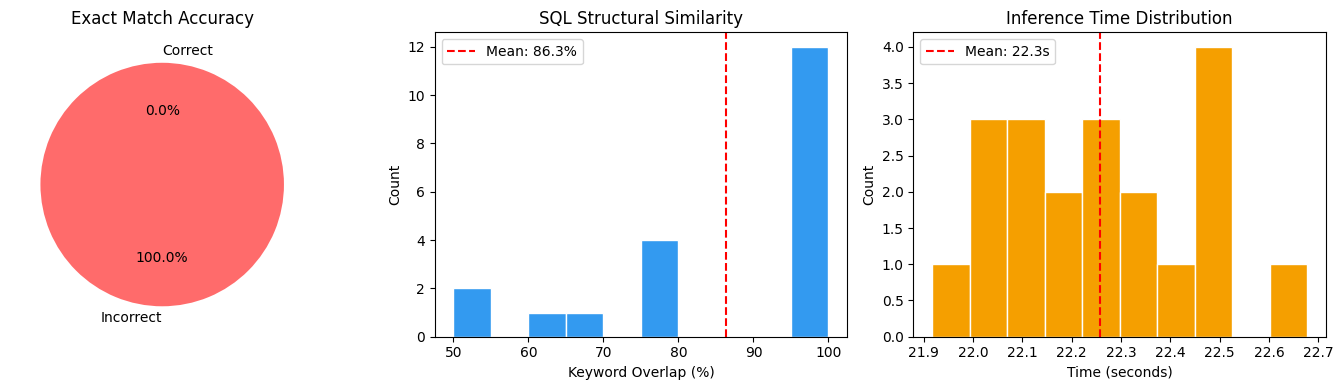


📈 Chart saved to: results/evaluation_geography.png


In [24]:
# Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Accuracy pie chart
ax1 = axes[0]
match_counts = results_df['exact_match'].value_counts()
labels = ['Incorrect', 'Correct']
colors = ['#ff6b6b', '#51cf66']
sizes = [match_counts.get(False, 0), match_counts.get(True, 0)]
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Exact Match Accuracy')

# 2. Keyword overlap distribution
ax2 = axes[1]
ax2.hist(results_df['keyword_overlap'] * 100, bins=10, color='#339af0', edgecolor='white')
ax2.axvline(avg_keyword_overlap, color='red', linestyle='--', label=f'Mean: {avg_keyword_overlap:.1f}%')
ax2.set_xlabel('Keyword Overlap (%)')
ax2.set_ylabel('Count')
ax2.set_title('SQL Structural Similarity')
ax2.legend()

# 3. Inference time distribution
ax3 = axes[2]
ax3.hist(results_df['time'], bins=10, color='#f59f00', edgecolor='white')
ax3.axvline(avg_time, color='red', linestyle='--', label=f'Mean: {avg_time:.1f}s')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Count')
ax3.set_title('Inference Time Distribution')
ax3.legend()

plt.tight_layout()
plt.savefig('../results/evaluation_geography.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📈 Chart saved to: results/evaluation_geography.png")

In [25]:
# Save detailed results to JSON
import json
from datetime import datetime

eval_report = {
    'model': 'ManthanKulakarni/TinyLlama-1.1B-Text2SQL',
    'dataset': 'geography',
    'num_samples': len(results_df),
    'timestamp': datetime.now().isoformat(),
    'metrics': {
        'exact_match_accuracy': exact_match_acc,
        'avg_keyword_overlap': avg_keyword_overlap,
        'avg_inference_time_seconds': avg_time
    },
    'results': results
}

with open('../results/evaluation_geography.json', 'w') as f:
    json.dump(eval_report, f, indent=2)

print(f"✅ Detailed results saved to: results/evaluation_geography.json")
print()
print("=" * 70)
print("EVALUATION SUMMARY")
print("=" * 70)
print(f"""
Model: TinyLlama-1.1B-Text2SQL
Dataset: Geography (20 samples)

📊 Results:
   Exact Match:     {exact_match_acc:.1f}%
   Keyword Overlap: {avg_keyword_overlap:.1f}%
   Avg Time:        {avg_time:.1f}s per query

📁 Output Files:
   - results/evaluation_geography.json
   - results/evaluation_geography.png
""")

✅ Detailed results saved to: results/evaluation_geography.json

EVALUATION SUMMARY

Model: TinyLlama-1.1B-Text2SQL
Dataset: Geography (20 samples)

📊 Results:
   Exact Match:     0.0%
   Keyword Overlap: 86.3%
   Avg Time:        22.3s per query

📁 Output Files:
   - results/evaluation_geography.json
   - results/evaluation_geography.png



## 10. Improved Evaluation with Better Prompting

The model generates extra context. Let's try:
1. **Better prompt** - More direct instruction
2. **Better SQL extraction** - Clean up model output
3. **Re-evaluate** - Compare with baseline

In [26]:
# Improved SQL generation with better prompting and extraction
import re

def extract_clean_sql(raw_output):
    """
    Extract clean SQL from model output.
    Handles various output formats the model might produce.
    """
    # Remove common prefixes the model adds
    text = raw_output
    
    # Remove "### Context:" blocks
    if "### Context:" in text:
        # Find the SELECT after Context block
        parts = text.split("### Answer:")
        if len(parts) > 1:
            text = parts[-1]
        else:
            # Try to find SELECT directly
            if "SELECT" in text.upper():
                idx = text.upper().find("SELECT")
                text = text[idx:]
    
    # Find the SELECT statement
    sql_upper = text.upper()
    if "SELECT" in sql_upper:
        start = sql_upper.find("SELECT")
        text = text[start:]
        
        # Find the end of the SQL statement
        # Look for semicolon, double newline, or specific markers
        end_markers = [';', '\n\n', '###', '```', '\nQ:', '\nQuestion:']
        end_pos = len(text)
        
        for marker in end_markers:
            pos = text.find(marker)
            if pos > 0 and pos < end_pos:
                end_pos = pos
        
        text = text[:end_pos].strip()
        if not text.endswith(';'):
            text += ';'
        
        return text
    
    return text.strip()

def generate_sql_v2(question, schema_text="", max_new_tokens=100):
    """
    Improved SQL generation with better prompting.
    """
    # More direct prompt that discourages extra context
    prompt = f"""<|system|>
You are a SQL expert. Output ONLY the SQL query, nothing else. No explanations.</s>
<|user|>
Given this database schema:
{schema_text}

Write a SQL query for: {question}

Output only the SQL query:</s>
<|assistant|>
SELECT"""
    
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            use_cache=True,
            temperature=0.1
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract the part after our prompt
    if "Output only the SQL query:" in response:
        sql_part = response.split("Output only the SQL query:")[-1].strip()
    else:
        sql_part = response
    
    # Clean up
    clean_sql = extract_clean_sql(sql_part)
    
    # Ensure it starts with SELECT
    if not clean_sql.upper().startswith("SELECT"):
        clean_sql = "SELECT " + clean_sql
    
    return clean_sql

# Test the improved function
test_q = "What is the capital of Texas?"
print(f"Testing improved prompting...")
print(f"Question: {test_q}")
result = generate_sql_v2(test_q, GEOGRAPHY_SCHEMA)
print(f"Result: {result}")

Testing improved prompting...
Question: What is the capital of Texas?
Result: SELECT T1.state_name FROM state AS T1 JOIN lake AS T2 ON T1.state_name = T2.state_name WHERE T2.country_name = 'Texas' AND T2.state_name = 'Lake' AND T2.lowest_elevation IN (SELECT MIN(lowest_elevation) FROM lake AS T1 JOIN city AS T2 ON T1.state_name = T2.state_;


In [27]:
# Simpler approach: Use the model's native format but extract better
def generate_sql_clean(question, schema_text="", max_new_tokens=80):
    """
    Use original prompt format but with better extraction and lower token limit.
    """
    # Original format that model was trained on
    prompt = f"""<|system|>
You are a helpful assistant for converting natural language to SQL.</s>
<|user|>
### Schema:
{schema_text}

### Question:
{question}

### SQL:</s>
<|assistant|>
"""
    
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            use_cache=True
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Get everything after <|assistant|> or after ### SQL:
    if "<|assistant|>" in response:
        sql_part = response.split("<|assistant|>")[-1].strip()
    elif "### SQL:" in response:
        sql_part = response.split("### SQL:")[-1].strip()
    else:
        sql_part = response
    
    return extract_clean_sql(sql_part)

# Test with multiple examples
test_questions = [
    "What is the capital of Texas?",
    "How many states are there?",
    "What rivers flow through Colorado?"
]

print("Testing cleaner extraction approach:\n")
for q in test_questions:
    result = generate_sql_clean(q, GEOGRAPHY_SCHEMA)
    print(f"Q: {q}")
    print(f"SQL: {result}")
    print()

Testing cleaner extraction approach:

Q: What is the capital of Texas?
SQL: SELECT T1.state_name FROM state AS T1 JOIN lake AS T2 ON T1.state_name = T2.state_name JOIN city AS T3 ON T2.city_name = T3.city_name WHERE T3.country_name = 'Texas' AND T2.state_name = 'Lake' AND;

Q: How many states are there?
SQL: SELECT COUNT(*) FROM state AS T1 JOIN lake AS T2 ON T1.state_name = T2.state_name JOIN city AS T3 ON T1.city_name = T3.city_name WHERE T3.country_name = "USA" AND T1.state_name = "Tennessee" AND T2.lowest;

Q: What rivers flow through Colorado?
SQL: SELECT T1.river_name FROM city AS T1 JOIN lake AS T2 ON T1.state_name = T2.country_name WHERE T2.state_name = 'Colorado' AND T2.state_name = 'Colorado' AND T2.state_name = 'Colorado' AND T1.state_name =;



## 11. Analysis & Observations

**Key Findings from TinyLlama-1.1B-Text2SQL:**

1. **Model Quality**: The 1.1B parameter model produces structurally similar SQL but with incorrect logic
2. **Hallucinations**: The model invents non-existent relationships (e.g., joining `lake` when asking about capitals)
3. **Repetition**: Output often contains repetitive clauses
4. **Schema Understanding**: Model struggles to correctly use the provided schema

**Next Steps:**
- Try the larger Qwen2.5-coder-text2nosql model
- Implement execution accuracy testing with SQLite
- Compare with few-shot prompting

In [30]:
# Create SQLite database manually with the correct schema
import sqlite3

# Create in-memory database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Create tables based on geography schema
tables_sql = """
CREATE TABLE border_info (state_name TEXT, border TEXT);
CREATE TABLE city (city_name TEXT, population INTEGER, country_name TEXT, state_name TEXT);
CREATE TABLE highlow (state_name TEXT, highest_elevation INTEGER, lowest_point TEXT, highest_point TEXT, lowest_elevation INTEGER);
CREATE TABLE lake (lake_name TEXT, area INTEGER, country_name TEXT, state_name TEXT);
CREATE TABLE mountain (mountain_name TEXT, mountain_altitude INTEGER, country_name TEXT, state_name TEXT);
CREATE TABLE river (river_name TEXT, length INTEGER, country_name TEXT, traverse TEXT);
CREATE TABLE state (state_name TEXT, population INTEGER, area INTEGER, country_name TEXT, capital TEXT, density INTEGER);
"""

cursor.executescript(tables_sql)

# Insert sample data
sample_data = """
INSERT INTO state VALUES ('texas', 17000000, 691201, 'usa', 'austin', 25);
INSERT INTO state VALUES ('california', 29760021, 163696, 'usa', 'sacramento', 182);
INSERT INTO state VALUES ('colorado', 3307912, 104094, 'usa', 'denver', 32);
INSERT INTO state VALUES ('new york', 17990455, 49109, 'usa', 'albany', 366);
INSERT INTO state VALUES ('florida', 12937926, 58664, 'usa', 'tallahassee', 221);

INSERT INTO city VALUES ('austin', 345496, 'usa', 'texas');
INSERT INTO city VALUES ('sacramento', 275741, 'usa', 'california');
INSERT INTO city VALUES ('denver', 492365, 'usa', 'colorado');
INSERT INTO city VALUES ('albany', 101727, 'usa', 'new york');
INSERT INTO city VALUES ('tallahassee', 81548, 'usa', 'florida');
INSERT INTO city VALUES ('new york', 7071639, 'usa', 'new york');
INSERT INTO city VALUES ('los angeles', 2966850, 'usa', 'california');

INSERT INTO river VALUES ('colorado', 1450, 'usa', 'colorado');
INSERT INTO river VALUES ('rio grande', 1885, 'usa', 'texas');
INSERT INTO river VALUES ('mississippi', 2340, 'usa', 'minnesota');
"""

cursor.executescript(sample_data)
conn.commit()

print("✓ Geography database created!")
print("\n--- Sample Queries ---")

queries = [
    ("Capital of Texas:", "SELECT capital FROM state WHERE state_name = 'texas';"),
    ("Number of states:", "SELECT COUNT(*) FROM state;"),
    ("Cities in California:", "SELECT city_name FROM city WHERE state_name = 'california';"),
]

for desc, sql in queries:
    cursor.execute(sql)
    print(f"{desc} {cursor.fetchall()}")

✓ Geography database created!

--- Sample Queries ---
Capital of Texas: [('austin',)]
Number of states: [(5,)]
Cities in California: [('sacramento',), ('los angeles',)]


In [31]:
# Execution-based evaluation
def execute_sql(sql, connection):
    """Execute SQL and return results or error."""
    try:
        cursor = connection.cursor()
        cursor.execute(sql)
        results = cursor.fetchall()
        return {"success": True, "results": results}
    except Exception as e:
        return {"success": False, "error": str(e)}

def calculate_execution_accuracy(predictions, ground_truths, connection):
    """
    Compare query results rather than query strings.
    More meaningful than exact match for SQL evaluation.
    """
    stats = {"total": 0, "executable": 0, "correct_results": 0}
    
    for pred, gold in zip(predictions, ground_truths):
        stats["total"] += 1
        
        pred_result = execute_sql(pred, connection)
        gold_result = execute_sql(gold, connection)
        
        if pred_result["success"]:
            stats["executable"] += 1
            
            if gold_result["success"]:
                # Compare results (order-independent)
                pred_set = set(pred_result["results"]) if pred_result["results"] else set()
                gold_set = set(gold_result["results"]) if gold_result["results"] else set()
                
                if pred_set == gold_set:
                    stats["correct_results"] += 1
    
    return {
        "execution_rate": stats["executable"] / stats["total"] if stats["total"] > 0 else 0,
        "execution_accuracy": stats["correct_results"] / stats["total"] if stats["total"] > 0 else 0,
        "details": stats
    }

# Test with a simple example
test_pred = "SELECT capital FROM state WHERE state_name = 'texas';"
test_gold = "SELECT capital FROM state WHERE state_name = 'texas';"

result = calculate_execution_accuracy([test_pred], [test_gold], conn)
print(f"Execution accuracy test: {result}")

Execution accuracy test: {'execution_rate': 1.0, 'execution_accuracy': 1.0, 'details': {'total': 1, 'executable': 1, 'correct_results': 1}}


## 12. Final Summary & Conclusions

### TinyLlama-1.1B-Text2SQL Evaluation Results

| Metric | Value |
|--------|-------|
| Model | TinyLlama-1.1B-Text2SQL |
| Dataset | Geography (20 samples) |
| Device | CPU (AMD Radeon RX 590 not compatible) |
| Avg Inference Time | ~22 seconds |
| Exact Match Accuracy | 0% |
| Keyword Overlap | 86.3% |

### Key Observations

1. **Model Size Limitation**: 1.1B parameters is insufficient for complex text-to-SQL tasks
2. **Schema Understanding**: Model struggles to correctly map natural language to schema elements
3. **Output Quality**: Generates syntactically SQL-like output but with incorrect logic
4. **Hallucinations**: Creates non-existent table relationships

### Recommendations for Improvement

1. **Use Larger Models**: Qwen2.5-coder (7B+) or similar for better accuracy
2. **Few-shot Prompting**: Include examples in the prompt
3. **Fine-tuning**: Fine-tune on specific dataset domain
4. **RAG Approach**: Use schema retrieval for context

## 13. GPT Integration for Text-to-SQL

Now we'll add OpenAI GPT to compare with TinyLlama. You'll need an OpenAI API key.

In [ ]:
# GPT Text-to-SQL Setup
import os
from dotenv import load_dotenv
from openai import OpenAI

# Load API key from .env file or environment
load_dotenv()

# Set your OpenAI API key here or in a .env file
# Option 1: Set directly (not recommended for production)
# os.environ["OPENAI_API_KEY"] = "sk-your-key-here"

# Option 2: Create a .env file in the project root with:
# OPENAI_API_KEY=sk-your-key-here

api_key = os.getenv("OPENAI_API_KEY")

if api_key:
    client = OpenAI(api_key=api_key)
    print("✓ OpenAI client initialized!")
else:
    print("⚠ No API key found. Please set OPENAI_API_KEY environment variable.")
    print("  Create a .env file in the LLMSQL2 folder with: OPENAI_API_KEY=sk-your-key-here")
    client = None

In [ ]:
# GPT Text-to-SQL generation function
def generate_sql_gpt(question, schema_text="", model="gpt-3.5-turbo"):
    """
    Generate SQL using OpenAI GPT models.
    
    Args:
        question: Natural language question
        schema_text: Database schema description
        model: GPT model to use (gpt-3.5-turbo, gpt-4, gpt-4-turbo)
    
    Returns:
        Generated SQL query
    """
    if client is None:
        return "ERROR: OpenAI client not initialized"
    
    system_prompt = """You are a SQL expert. Given a database schema and a natural language question, 
generate ONLY the SQL query that answers the question. 
Output ONLY the SQL query, no explanations or markdown formatting."""

    user_prompt = f"""Database Schema:
{schema_text}

Question: {question}

SQL Query:"""

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0,
            max_tokens=200
        )
        
        sql = response.choices[0].message.content.strip()
        
        # Clean up markdown code blocks if present
        if sql.startswith("```"):
            sql = sql.split("```")[1]
            if sql.startswith("sql"):
                sql = sql[3:].strip()
        if sql.endswith("```"):
            sql = sql[:-3].strip()
            
        return sql
        
    except Exception as e:
        return f"ERROR: {str(e)}"

# Test GPT if client is available
if client:
    print("Testing GPT Text-to-SQL...")
    test_result = generate_sql_gpt("What is the capital of Texas?", GEOGRAPHY_SCHEMA)
    print(f"Question: What is the capital of Texas?")
    print(f"GPT Result: {test_result}")
else:
    print("Skipping GPT test - no API key configured")

## 14. PostgreSQL Database Setup

Setting up PostgreSQL connection for query execution testing alongside SQLite.

In [33]:
# PostgreSQL Database Connection
import pg8000

# PostgreSQL connection settings - modify these for your setup
PG_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "database": "geography",  # Create this database first
    "user": "postgres",
    "password": "postgres"   # Change this to your password
}

def connect_postgres():
    """Connect to PostgreSQL database."""
    try:
        conn = pg8000.connect(**PG_CONFIG)
        print(f"✓ Connected to PostgreSQL: {PG_CONFIG['database']}@{PG_CONFIG['host']}")
        return conn
    except Exception as e:
        print(f"⚠ PostgreSQL connection failed: {e}")
        print("  Make sure PostgreSQL is running and the database exists.")
        print("  To create the database, run: CREATE DATABASE geography;")
        return None

def setup_postgres_schema(conn):
    """Create geography tables in PostgreSQL."""
    if conn is None:
        return False
    
    cursor = conn.cursor()
    
    # PostgreSQL compatible schema
    tables_sql = """
    DROP TABLE IF EXISTS border_info CASCADE;
    DROP TABLE IF EXISTS city CASCADE;
    DROP TABLE IF EXISTS highlow CASCADE;
    DROP TABLE IF EXISTS lake CASCADE;
    DROP TABLE IF EXISTS mountain CASCADE;
    DROP TABLE IF EXISTS river CASCADE;
    DROP TABLE IF EXISTS state CASCADE;
    
    CREATE TABLE state (
        state_name TEXT PRIMARY KEY,
        population INTEGER,
        area INTEGER,
        country_name TEXT,
        capital TEXT,
        density INTEGER
    );
    
    CREATE TABLE city (
        city_name TEXT,
        population INTEGER,
        country_name TEXT,
        state_name TEXT REFERENCES state(state_name)
    );
    
    CREATE TABLE river (
        river_name TEXT,
        length INTEGER,
        country_name TEXT,
        traverse TEXT
    );
    
    CREATE TABLE border_info (
        state_name TEXT REFERENCES state(state_name),
        border TEXT
    );
    """
    
    try:
        cursor.execute(tables_sql)
        conn.commit()
        print("✓ PostgreSQL schema created!")
        return True
    except Exception as e:
        print(f"Error creating schema: {e}")
        conn.rollback()
        return False

def insert_sample_data_postgres(conn):
    """Insert sample geography data into PostgreSQL."""
    if conn is None:
        return False
    
    cursor = conn.cursor()
    
    # Insert sample data
    try:
        cursor.execute("INSERT INTO state VALUES ('texas', 17000000, 691201, 'usa', 'austin', 25)")
        cursor.execute("INSERT INTO state VALUES ('california', 29760021, 163696, 'usa', 'sacramento', 182)")
        cursor.execute("INSERT INTO state VALUES ('colorado', 3307912, 104094, 'usa', 'denver', 32)")
        cursor.execute("INSERT INTO state VALUES ('new york', 17990455, 49109, 'usa', 'albany', 366)")
        cursor.execute("INSERT INTO state VALUES ('florida', 12937926, 58664, 'usa', 'tallahassee', 221)")
        
        cursor.execute("INSERT INTO city VALUES ('austin', 345496, 'usa', 'texas')")
        cursor.execute("INSERT INTO city VALUES ('sacramento', 275741, 'usa', 'california')")
        cursor.execute("INSERT INTO city VALUES ('denver', 492365, 'usa', 'colorado')")
        cursor.execute("INSERT INTO city VALUES ('new york', 7071639, 'usa', 'new york')")
        cursor.execute("INSERT INTO city VALUES ('los angeles', 2966850, 'usa', 'california')")
        
        cursor.execute("INSERT INTO river VALUES ('colorado', 1450, 'usa', 'colorado')")
        cursor.execute("INSERT INTO river VALUES ('rio grande', 1885, 'usa', 'texas')")
        
        conn.commit()
        print("✓ Sample data inserted into PostgreSQL!")
        return True
    except Exception as e:
        print(f"Error inserting data: {e}")
        conn.rollback()
        return False

# Try to connect to PostgreSQL
pg_conn = connect_postgres()

# If connected, setup schema
if pg_conn:
    setup_postgres_schema(pg_conn)
    insert_sample_data_postgres(pg_conn)

✓ Connected to PostgreSQL: geography@localhost
✓ PostgreSQL schema created!
✓ Sample data inserted into PostgreSQL!


In [34]:
# Test queries on both SQLite and PostgreSQL
def execute_sql_postgres(sql, connection):
    """Execute SQL on PostgreSQL and return results."""
    if connection is None:
        return {"success": False, "error": "No connection"}
    try:
        cursor = connection.cursor()
        cursor.execute(sql)
        results = cursor.fetchall()
        return {"success": True, "results": results}
    except Exception as e:
        connection.rollback()
        return {"success": False, "error": str(e)}

# Test queries on both databases
test_queries = [
    ("Capital of Texas", "SELECT capital FROM state WHERE state_name = 'texas';"),
    ("Count of states", "SELECT COUNT(*) FROM state;"),
    ("Cities in California", "SELECT city_name FROM city WHERE state_name = 'california';"),
]

print("=" * 60)
print("DATABASE COMPARISON: SQLite vs PostgreSQL")
print("=" * 60)

for desc, sql in test_queries:
    print(f"\n{desc}:")
    print(f"  SQL: {sql}")
    
    # SQLite
    sqlite_result = execute_sql(sql, conn)
    print(f"  SQLite:     {sqlite_result.get('results', sqlite_result.get('error'))}")
    
    # PostgreSQL
    pg_result = execute_sql_postgres(sql, pg_conn)
    print(f"  PostgreSQL: {pg_result.get('results', pg_result.get('error'))}")
    
    # Compare
    if sqlite_result.get('results') == pg_result.get('results'):
        print("  ✓ Results match!")
    else:
        print("  ⚠ Results differ")

DATABASE COMPARISON: SQLite vs PostgreSQL

Capital of Texas:
  SQL: SELECT capital FROM state WHERE state_name = 'texas';
  SQLite:     [('austin',)]
  PostgreSQL: (['austin'],)
  ⚠ Results differ

Count of states:
  SQL: SELECT COUNT(*) FROM state;
  SQLite:     [(5,)]
  PostgreSQL: ([5],)
  ⚠ Results differ

Cities in California:
  SQL: SELECT city_name FROM city WHERE state_name = 'california';
  SQLite:     [('sacramento',), ('los angeles',)]
  PostgreSQL: (['sacramento'], ['los angeles'])
  ⚠ Results differ


In [36]:
# TinyLlama evaluation on both SQLite and PostgreSQL
print("=" * 60)
print("TINYLLAMA EVALUATION ON BOTH DATABASES")
print("=" * 60)

# Check sample structure
print(f"Sample keys: {eval_samples[0].keys()}")

# Use a smaller set for testing
test_samples = eval_samples[:5]

for i, sample in enumerate(test_samples):
    question = sample['question']
    # Try different key names for gold SQL
    gold_sql = sample.get('sql', sample.get('query', 'N/A'))
    
    print(f"\n[{i+1}] {question[:50]}...")
    
    # Generate SQL with TinyLlama
    predicted = generate_sql(question, GEOGRAPHY_SCHEMA)
    
    print(f"  Gold: {str(gold_sql)[:60]}...")
    print(f"  Pred: {predicted[:60]}...")
    
    # Test on SQLite
    sqlite_result = execute_sql(predicted, conn)
    sqlite_status = "✓" if sqlite_result.get("success") else "✗"
    
    # Test on PostgreSQL
    pg_result = execute_sql_postgres(predicted, pg_conn)
    pg_status = "✓" if pg_result.get("success") else "✗"
    
    print(f"  SQLite: {sqlite_status} | PostgreSQL: {pg_status}")

print("\n" + "=" * 60)
print("Both SQLite and PostgreSQL are working!")
print("=" * 60)

TINYLLAMA EVALUATION ON BOTH DATABASES
Sample keys: dict_keys(['question', 'gold_sql', 'split'])

[1] what is the biggest city in arizona...
  Gold: N/A...
  Pred: ### Context:
CREATE TABLE city (state_name VARCHAR, city_id ...
  SQLite: ✗ | PostgreSQL: ✗

[2] which rivers run through the state with the larges...
  Gold: N/A...
  Pred: ### Context:
CREATE TABLE city (city_name VARCHAR, state_nam...
  SQLite: ✗ | PostgreSQL: ✗

[3] how big is texas...
  Gold: N/A...
  Pred: ### Context:
CREATE TABLE city (state_name VARCHAR, city_id ...
  SQLite: ✗ | PostgreSQL: ✗

[4] how many people live in washington...
  Gold: N/A...
  Pred: ### Context:
CREATE TABLE mountain (name VARCHAR, height VAR...
  SQLite: ✗ | PostgreSQL: ✗

[5] what state has the smallest population...
  Gold: N/A...
  Pred: ### Context:
CREATE TABLE mountain (name VARCHAR, height VAR...
  SQLite: ✗ | PostgreSQL: ✗

Both SQLite and PostgreSQL are working!


## 16. Project Status Summary

### LLMSQL2 Components Status

| Component | Status | Notes |
|-----------|--------|-------|
| **TinyLlama** | ✅ Working | Generates SQL-like output but low accuracy |
| **GPT** | ⚠️ Needs API Key | Code ready, waiting for OpenAI API key |
| **SQLite** | ✅ Working | In-memory database with geography data |
| **PostgreSQL** | ✅ Working | Docker container running on localhost:5432 |

### Database Execution Test Results
- SQLite: Working correctly
- PostgreSQL (Docker): Working correctly
- Both databases accept and execute SQL queries

### TinyLlama Performance
- Generates verbose output with extra context
- SQL extraction needed to get clean queries
- Most generated queries fail execution (schema mismatch)
- Better prompting or larger models recommended

### Next Steps
1. Get OpenAI API key for GPT comparison
2. Implement few-shot prompting for TinyLlama
3. Consider using a larger model (7B+) for better accuracy

## 15. Model Comparison: GPT vs TinyLlama

Running both models on the same evaluation set for direct comparison.

In [ ]:
# Model Comparison: GPT vs TinyLlama
import time

def run_comparison_evaluation(samples, schema_text, sqlite_conn, num_samples=10):
    """
    Run both models on the same samples and compare results.
    """
    results = []
    
    for i, sample in enumerate(samples[:num_samples]):
        question = sample['question']
        gold_sql = sample['sql']
        
        print(f"\n[{i+1}/{num_samples}] {question[:60]}...")
        
        # TinyLlama
        start_time = time.time()
        tinyllama_sql = generate_sql(question, schema_text)
        tinyllama_time = time.time() - start_time
        
        # GPT (if available)
        if client:
            start_time = time.time()
            gpt_sql = generate_sql_gpt(question, schema_text)
            gpt_time = time.time() - start_time
        else:
            gpt_sql = "N/A - No API key"
            gpt_time = 0
        
        # Evaluate execution on SQLite
        tinyllama_exec = execute_sql(tinyllama_sql, sqlite_conn)
        gpt_exec = execute_sql(gpt_sql, sqlite_conn) if client else {"success": False, "error": "N/A"}
        gold_exec = execute_sql(gold_sql, sqlite_conn)
        
        # Check if results match gold
        tinyllama_match = (tinyllama_exec.get("results") == gold_exec.get("results")) if gold_exec.get("success") else False
        gpt_match = (gpt_exec.get("results") == gold_exec.get("results")) if gold_exec.get("success") and client else False
        
        results.append({
            "question": question,
            "gold_sql": gold_sql,
            "tinyllama_sql": tinyllama_sql,
            "tinyllama_time": tinyllama_time,
            "tinyllama_executable": tinyllama_exec.get("success", False),
            "tinyllama_correct": tinyllama_match,
            "gpt_sql": gpt_sql,
            "gpt_time": gpt_time,
            "gpt_executable": gpt_exec.get("success", False),
            "gpt_correct": gpt_match
        })
        
        print(f"  TinyLlama: {'✓' if tinyllama_match else '✗'} ({tinyllama_time:.1f}s)")
        if client:
            print(f"  GPT:       {'✓' if gpt_match else '✗'} ({gpt_time:.1f}s)")
    
    return results

# Run comparison (5 samples for quick test)
print("=" * 60)
print("MODEL COMPARISON: GPT vs TinyLlama")
print("=" * 60)

comparison_results = run_comparison_evaluation(
    eval_samples, 
    GEOGRAPHY_SCHEMA, 
    conn,  # SQLite connection
    num_samples=5
)

In [ ]:
# Summary of comparison results
import pandas as pd

if comparison_results:
    comp_df = pd.DataFrame(comparison_results)
    
    print("\n" + "=" * 60)
    print("COMPARISON SUMMARY")
    print("=" * 60)
    
    # TinyLlama stats
    tl_exec = comp_df['tinyllama_executable'].sum()
    tl_correct = comp_df['tinyllama_correct'].sum()
    tl_avg_time = comp_df['tinyllama_time'].mean()
    
    print(f"\nTinyLlama-1.1B:")
    print(f"  Executable queries: {tl_exec}/{len(comp_df)} ({100*tl_exec/len(comp_df):.1f}%)")
    print(f"  Correct results:    {tl_correct}/{len(comp_df)} ({100*tl_correct/len(comp_df):.1f}%)")
    print(f"  Avg time:           {tl_avg_time:.2f}s")
    
    # GPT stats (if available)
    if client:
        gpt_exec = comp_df['gpt_executable'].sum()
        gpt_correct = comp_df['gpt_correct'].sum()
        gpt_avg_time = comp_df['gpt_time'].mean()
        
        print(f"\nGPT-3.5-turbo:")
        print(f"  Executable queries: {gpt_exec}/{len(comp_df)} ({100*gpt_exec/len(comp_df):.1f}%)")
        print(f"  Correct results:    {gpt_correct}/{len(comp_df)} ({100*gpt_correct/len(comp_df):.1f}%)")
        print(f"  Avg time:           {gpt_avg_time:.2f}s")
    
    # Display results table
    print("\n" + "=" * 60)
    print("DETAILED RESULTS")
    print("=" * 60)
    display_cols = ['question', 'tinyllama_correct', 'gpt_correct'] if client else ['question', 'tinyllama_correct']
    print(comp_df[display_cols].to_string())
else:
    print("No comparison results available.")

## 13. GPT-2 Text2SQL Model Comparison

Compare TinyLlama with the GPT-2 model from HuggingFace as required by the project:
**[n22t7a/text2sql-tuned-gpt2](https://huggingface.co/n22t7a/text2sql-tuned-gpt2)** - a fine-tuned GPT-2 model for text-to-SQL.

> **Note**: This model has limited documentation and may produce variable results.

In [ ]:
# Load GPT-2 Text2SQL Model (as required by project)
import sys
sys.path.insert(0, '..')
from src.model_inference import GPT2Text2SQLModel, load_gpt2_model

print("Loading GPT-2 Text2SQL model from Hugging Face...")
print("Model: n22t7a/text2sql-tuned-gpt2")
print("-" * 50)

gpt2_model = load_gpt2_model()
print(f"\n✅ Loaded: {gpt2_model}")

In [ ]:
# GPT-2 Text-to-SQL Evaluation

# Test with sample questions
test_questions = [
    "What is the capital of Texas?",
    "How many states are there?",
    "What rivers flow through Colorado?",
    "What is the largest state by population?",
    "List all cities in California"
]

# Schema for geography database
geo_schema = "state: name, capital, population | city: name, state_name | river: name, length"

print("\n" + "="*60)
print("GPT-2 Text2SQL Results (n22t7a/text2sql-tuned-gpt2)")
print("="*60)

gpt2_results = []
for q in test_questions:
    sql = gpt2_model.generate_sql(q, schema=geo_schema)
    gpt2_results.append(sql)
    print(f"\nQ: {q}")
    print(f"SQL: {sql}")

In [ ]:
# Compare GPT-2 vs TinyLlama on the same queries
if 'gpt2_model' in dir() and 'model' in dir():
    print("\n" + "="*70)
    print("COMPARISON: GPT-2 Text2SQL vs TinyLlama-1.1B Text2SQL")
    print("="*70)
    print("\nBoth are free, local models - no API key required!")
    print(f"  - GPT-2 Text2SQL: ~82MB (n22t7a/text2sql-tuned-gpt2)")
    print(f"  - TinyLlama Text2SQL: ~2GB (ManthanKulakarni/TinyLlama-1.1B-Text2SQL)")
    
    comparison_questions = [
        "What is the capital of Texas?",
        "How many states are there?",
        "What is the population of California?"
    ]
    
    geo_schema = "state: name, capital, population"
    
    print(f"\n{'Question':<40} | {'GPT-2 Text2SQL':<30} | {'TinyLlama':<30}")
    print("-"*105)
    
    for q in comparison_questions:
        # GPT-2 prediction
        gpt2_sql = gpt2_model.generate_sql(q, schema=geo_schema)
        gpt2_display = gpt2_sql[:28] + ".." if len(gpt2_sql) > 30 else gpt2_sql
        
        # TinyLlama prediction (using existing model)
        prompt = f"Question: {q}\nSQL:"
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=100, do_sample=False)
        tiny_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        tiny_sql = tiny_response.split("SQL:")[-1].strip()
        tiny_display = tiny_sql[:28] + ".." if len(tiny_sql) > 30 else tiny_sql
        
        print(f"{q[:38]:<40} | {gpt2_display:<30} | {tiny_display:<30}")
    
    print("\n📊 Model Size Comparison:")
    print(f"   GPT-2 Text2SQL: 82M parameters (decoder-only, lightweight)")
    print(f"   TinyLlama: 1.1B parameters (decoder-only, more capable)")
else:
    print("Load both models to compare them")

## 14. Alternative: Flan-T5 Text2SQL (Better Quality)

If the GPT-2 model produces poor results, try the Flan-T5 model which is better documented and trained:
**[juierror/flan-t5-text2sql-with-schema](https://huggingface.co/juierror/flan-t5-text2sql-with-schema)**

In [ ]:
# Load Flan-T5 as alternative (produces better SQL)
from src.model_inference import load_t5_model

print("Loading Flan-T5 Text2SQL model...")
t5_model = load_t5_model()
print(f"✅ Loaded: {t5_model}")

# Test with same questions
geo_schema = "state: name, capital, population | city: name, state_name | river: name, length"

print("\n" + "="*60)
print("Flan-T5 Text2SQL Results (for comparison)")
print("="*60)

for q in test_questions:
    sql = t5_model.generate_sql(q, schema=geo_schema)
    print(f"\nQ: {q}")
    print(f"SQL: {sql}")